tgb - 3/19/2019 - This script aims at introducing a multiplicative-conserving network. For each conservation step, the vertical profiles are isolated on one side while the scalars are isolated on the other side. The vertical profiles are then multiplied by the right constant so that the invariant is conserved:
***
[PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN] as a function of:  
[QBP, QCBP, QIBP, TBP, VBP, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic, Tdt_adiabatic, Vdt_adiabatic, PS, SOLIN, SHFLX, LHFLX]  
***
to now predict:
***
[PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN] as a function of:  
[QBP, QCBP, QIBP, TBP, VBP, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic, Tdt_adiabatic, Vdt_adiabatic, PS, SOLIN, SHFLX, LHFLX] 
***  
Two remarks:  
1) The energy conservation constraint will now involve a mass-weighted integral of QRL and QRS, knowing that:  
$$
\int_{0}^{p_{s}}\frac{dp}{g}c_{p}QRL\left(p\right)=FLNS-FLNT
$$
$$
\int_{0}^{p_{s}}\frac{dp}{g}c_{p}QRS\left(p\right)=FSNT-FSNS
$$  
2) For consistency, we shoud calculate FLNS, FSNS as residuals from (QRL,FLNT) and (QRS,FSNS) respectively

In [2]:
#!ln -s /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain \
#/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.models import *
from cbrain.losses import *
from cbrain.utils import limit_mem
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp32fbp_andkua/'
PREFIX = '32_col_rad_12m_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

/home/t/Tom.Beucler/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


## 1) Create data generator and produce data sample


### 1.1) Create data generator from training dataset

In [3]:
train_gen_obj = DataGenerator(
    data_dir=TRAINDIR, 
    feature_fn=PREFIX+'train_shuffle_features.nc',
    target_fn=PREFIX+'train_shuffle_targets.nc',
    batch_size=512,
    norm_fn=PREFIX+'train_norm.nc',
    fsub='feature_means',   # Subtract the mean
    fdiv='feature_stds_by_var',    # Then divide by Std
    tmult='target_conv',    # For targets/output: use values from preprocess_aqua.
    shuffle=True,
)

Generator will have 9338880 samples in 18240 batches
Features have shape 304; targets have shape 218


In [4]:
gen = train_gen_obj.return_generator()
# Produce data sample
x, y = next(gen)
# and check its shape
x.shape, y.shape

((512, 304), (512, 218))

### 1.2) Create data generator from validation dataset and produce sample

In [5]:
valid_gen_obj = DataGenerator(
    data_dir=TRAINDIR, 
    feature_fn=PREFIX+'valid_shuffle_features.nc',
    target_fn=PREFIX+'valid_shuffle_targets.nc',
    batch_size=512,
    norm_fn=PREFIX+'train_norm.nc',
    fsub='feature_means',   # Subtracct the mean
    fdiv='feature_stds_by_var',    # Then divide by Std
    tmult='target_conv',    # For targets/output: use values from preprocess_aqua.
    shuffle=True,
)

Generator will have 3514368 samples in 6864 batches
Features have shape 304; targets have shape 218


In [6]:
validgen = valid_gen_obj.return_generator()

xval, yval = next(validgen)

xval.shape, yval.shape

((512, 304), (512, 218))

## 2) Building the custom layers for mass/energy multiplicative-conserving neural networks

## 2.1) Load all the normalization variables

In [8]:
# 1) Open the file containing the normalization of the targets
ds = xr.open_dataset(TRAINDIR + PREFIX + 'train_norm.nc')
# 2) Open the pickle files containing the pressure converters
with open(os.path.join('/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain', 'hyai_hybi.pkl'), 'rb') as f:
            hyai, hybi = pickle.load(f)
# 3) Define fsub, fdiv, normq
fsub = ds.feature_means.values
fdiv = ds.feature_stds_by_var.values
normq = ds.target_conv.values
print('fsub.shape=',fsub.shape)
print('fdiv.shape=',fdiv.shape)
print('normq.shape=',normq.shape)
print('hyai.shape=',hyai.shape)
print('hybi.shape=',hybi.shape)

ds.close()

fsub.shape= (304,)
fdiv.shape= (304,)
normq.shape= (218,)
hyai.shape= (31,)
hybi.shape= (31,)


## 2.2) Check radiative integrals in numpy
tgb - 2/8/2019 - We are checking that:
$$
\int_{0}^{p_{s}}\frac{dp}{g}c_{p}QRL\left(p\right)=FLNS-FLNT
$$
$$
\int_{0}^{p_{s}}\frac{dp}{g}c_{p}QRS\left(p\right)=FSNT-FSNS
$$  
Using the normalization to units W/m2, we are checking that:  
$$
\int_{0}^{\widetilde{p_{s}}}d\widetilde{p}\cdot\delta QRL=FLNS-FLNT
$$
$$
\int_{0}^{\widetilde{p_{s}}}d\widetilde{p}\cdot\delta QRS=FSNT-FSNS
$$
x = [QBP, QCBP, QIBP, TBP, VBP, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic, Tdt_adiabatic, Vdt_adiabatic, PS, SOLIN, SHFLX, LHFLX]  
y = [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]  
In this sub-section we have several objectives:  
1) Making sure that for y, the integral relation holds  
2) Coding the surface radiation layer in numpy  
3) Convert the surface radiation layer to tensorflow

### 2.2.1) Checking consistency of radiative-integrals

(array([  1.,   5.,  20., 305., 127.,  37.,   9.,   5.,   2.,   1.]),
 array([-7.37983379e-05, -5.51983819e-05, -3.65984259e-05, -1.79984699e-05,
         6.01486124e-07,  1.92014421e-05,  3.78013981e-05,  5.64013541e-05,
         7.50013101e-05,  9.36012661e-05,  1.12201222e-04]),
 <a list of 10 Patch objects>)

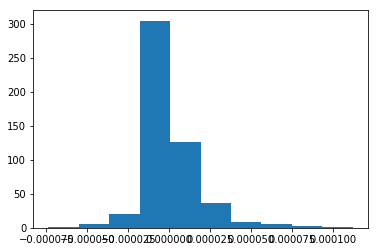

In [7]:
x,y = next(gen) # x.shape = 304 & y.shape = 218
import copy
inp = copy.copy(x)

# 0) Constants
C_P = 1.00464e3 # Specific heat capacity of air at constant pressure
G = 9.80616; # Reference gravity constant [m.s-2]
P0 = 1e5; # Reference surface pressure [Pa]
        
# 1) Get non-dimensional pressure differences (p_tilde above)
PS = np.add( np.multiply( inp[:,300], fdiv[300]), fsub[300])
# Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
P = np.add( np.multiply( P0, hyai), \
            np.multiply( PS[:,None], hybi))
dP = np.subtract( P[:, 1:], P[:, :-1])
# norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
dP_NORM = np.divide( \
                     np.multiply(normq[:30], \
                           G), L_V)
# dp_tilde = dp/dp_norm
# Wondering about broadcasting here...
# tf.div or simply \ would support broadcasting 
dP_TILD = np.divide( dP, dP_NORM)

# 2) Radiative integrals
SWVEC = np.multiply( dP_TILD, y[:, 150:180])
SWINT = np.sum( SWVEC, axis=1)
SWNET = y[:,210]-y[:,211] # FSNT-FSNS

LWVEC = np.multiply( dP_TILD, y[:, 120:150])
LWINT = np.sum( LWVEC, axis=1) # LW integral
LWNET = y[:,213]-y[:,212] # FLNS-FLNT

plt.hist(SWINT-SWNET)

### 2.2.2) Coding surface radiation layer in numpy
tgb - 3/19/2019 - The multiplicative conserving layer is simple in that the dimension of the layer remains unchanged.  
From: y = [PHQ(0-29), PHCLDLIQ(30-59), PHCLDICE(60-89), TPHYSTND(90-119), QRL(120-149), QRS(150-179), DTVKE(180-209), FSNT(210), FSNS(211), FLNT(212), FLNS(213), PRECT(214), PRECTEND(215), PRECST(216), PRECSTEN(217)], we need to isolate:  
y_left = QRS(150-179) & y_right = FSNT(210), FSNS(211)  
y_left = QRL(120-149) & y_right = FLNT(212), FLNS(213)  
  
y_right may be 0 in the shortwave case at night; in that particular case, it is OK to multiply y_left by 0 because y_left is identically 0 throughout the column at night.
****
To be consistent, the radiative integrals need to verify:
$$
\int sw\frac{dp}{g}=\mathrm{NETSW},
$$
$$
\int lw\frac{dp}{g}=\mathrm{NETLW}.
$$
Starting from the profiles $sw_{0}\left(p\right),lw_{0}\left(p\right)\ $and
the net radiative fluxes $\mathrm{NETSW}_{0},\mathrm{NETLW}_{0}$,
we simply multiply the profiles by a constant to satisfy the radiative
integral relation:
$$
sw=sw_{0}\times\frac{\mathrm{NETSW}_{0}}{\int sw_{0}dp/g},
$$
$$
lw=lw_{0}\times\frac{\mathrm{NETLW}_{0}}{\int lw_{0}dp/g}.
$$

(array([  8.,  34.,   2., 106.,  15., 211.,  97.,   0.,  33.,   6.]),
 array([-8.52651283e-14, -6.82121026e-14, -5.11590770e-14, -3.41060513e-14,
        -1.70530257e-14,  0.00000000e+00,  1.70530257e-14,  3.41060513e-14,
         5.11590770e-14,  6.82121026e-14,  8.52651283e-14]),
 <a list of 10 Patch objects>)

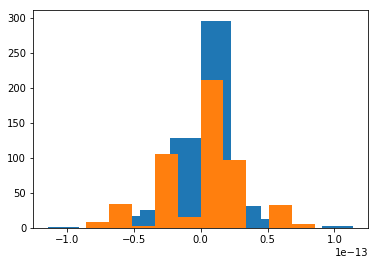

In [8]:
x,y = next(gen) # x.shape = 304 & y.shape = 218
import copy
inp = copy.copy(x)

# Mimic vector that comes in
ybef = copy.copy(y)
# Introduce random noise to mimic the effect of a NN that deviates from the truth
ybef = ybef+np.random.normal(0,1,(ybef.shape[0],ybef.shape[1]))
yaft = copy.copy(ybef)

# 0) Constants
C_P = 1.00464e3 # Specific heat capacity of air at constant pressure
G = 9.80616; # Reference gravity constant [m.s-2]
P0 = 1e5; # Reference surface pressure [Pa]
        
# 1) Get non-dimensional pressure differences (p_tilde above)
PS = np.add( np.multiply( inp[:,300], fdiv[300]), fsub[300])
# Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
P = np.add( np.multiply( P0, hyai), \
            np.multiply( PS[:,None], hybi))
dP = np.subtract( P[:, 1:], P[:, :-1])
# norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
dP_NORM = np.divide( \
                     np.multiply(normq[:30], \
                           G), L_V)
# dp_tilde = dp/dp_norm
# Wondering about broadcasting here...
# tf.div or simply \ would support broadcasting 
dP_TILD = np.divide( dP, dP_NORM)

# 2) Radiative integrals
SWVEC = np.multiply( dP_TILD, ybef[:, 150:180])
SWINT = np.sum( SWVEC, axis=1)
SWNET = ybef[:,210]-ybef[:,211] # FSNT-FSNS
SWRAT = np.divide( SWNET, SWINT)
yaft[:, 150:180] = np.multiply( np.expand_dims(SWRAT,1), ybef[:, 150:180])
#print(SWRAT)

LWVEC = np.multiply( dP_TILD, ybef[:, 120:150])
LWINT = np.sum( LWVEC, axis=1) # LW integral
LWNET = ybef[:,213]-ybef[:,212] # FLNS-FLNT
LWRAT = np.divide( LWNET, LWINT)
yaft[:, 120:150] = np.multiply( np.expand_dims(LWRAT,1), ybef[:, 120:150])
#print(LWRAT)

# 3) Check energy conservation after multiplication
SWVEC = np.multiply( dP_TILD, yaft[:, 150:180])
SWINT = np.sum( SWVEC, axis=1)
SWNET = yaft[:,210]-yaft[:,211] # FSNT-FSNS

plt.hist(SWINT-SWNET)

LWVEC = np.multiply( dP_TILD, yaft[:, 120:150])
LWINT = np.sum( LWVEC, axis=1) # LW integral
LWNET = yaft[:,213]-yaft[:,212] # FLNS-FLNT

plt.hist(LWINT-LWNET)
#plt.hist(yaft[:,210]-y[:,210])
#plt.hist(yaft[:,211]-y[:,211])

### 3.2.3) Port the surface radiation layer to tensorflow

In [25]:
class MulSurRadLay(Layer):
    
    def __init__(self, fsub, fdiv, normq, hyai, hybi, eps, output_dim, **kwargs):
        self.fsub = fsub # Subtraction for normalization of inputs 
        self.fdiv = fdiv # Division for normalization of inputs
        self.normq = normq # Normalization of output's water concentration
        self.hyai = hyai # CAM constants to calculate d_pressure
        self.hybi = hybi # CAM constants to calculate d_pressure
        self.eps = eps # Minimal denominator when calculating ratio (W/m2)
        self.output_dim = output_dim # Dimension of output
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!
    
    # tgb - 2/6/2019 - following https://github.com/keras-team/keras/issues/4871
    def get_config(self):
        config = {'fsub': list(self.fsub), 'fdiv': list(self.fdiv),
                  'normq': list(self.normq), 'hyai': list(self.hyai),
                  'hybi': list(self.hybi), 'eps': list(self.eps),
                  'output_dim': self.output_dim}
        base_config = super(MulSurRadLay, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def call(self, arrs):
    
        # Split between the inputs inp & the output of the densely connected
        # neural network, massout
        inp, densout = arrs
        
        # 0) Constants
        C_P = 1.00464e3 # Specific heat capacity of air at constant pressure
        G = 9.80616; # Reference gravity constant [m.s-2]
        L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
        P0 = 1e5; # Reference surface pressure [Pa]

        # 1) Get non-dimensional pressure differences (p_tilde above)
        PS = tfm.add( tfm.multiply( inp[:,300], self.fdiv[300]), self.fsub[300])
        # Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
        P = tfm.add( tfm.multiply( P0, self.hyai), \
                    tfm.multiply( PS[:,None], self.hybi))
        dP = tfm.subtract( P[:, 1:], P[:, :-1])
        # norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
        dP_NORM = tfm.divide( \
                             tfm.multiply(self.normq[:30], \
                                          G),\
                             L_V)
        # dp_tilde = dp/dp_norm
        dP_TILD = tfm.divide( dP, dP_NORM)

        # 2) Radiative integrals
        SWVEC = tfm.multiply( dP_TILD, densout[:, 150:180])
        SWINT = tfm.reduce_sum( SWVEC, axis=1)

        LWVEC = tfm.multiply( dP_TILD, densout[:, 120:150])
        LWINT = tfm.reduce_sum( LWVEC, axis=1) # LW integral

        # 3) Calculate SW/LW ratio to match the radiative integral
        SWRAT = tfm.divide( tfm.subtract(densout[:,210],\
                                         densout[:,211]),\
                           tfm.multiply(tfm.sign(SWINT),\
                                        tfm.maximum(tfm.abs(SWINT), self.eps)))
        LWRAT = tfm.divide( tfm.subtract(densout[:,213],\
                                         densout[:,212]),\
                           tfm.multiply(tfm.sign(LWINT),\
                                        tfm.maximum(tfm.abs(LWINT), self.eps)))

        # 4) Multiply the vertical SW/LW profiles to match the net flux
        out = tf.concat([densout[:, :120],\
                         tfm.multiply(densout[:,120:150],tf.expand_dims(LWRAT,axis=1)),\
                         tfm.multiply(densout[:,150:180],tf.expand_dims(SWRAT,axis=1)),\
                        densout[:, 180:218]],1)
        return out
    
    def compute_output_shape(self, input_shape):
        # tgb - 2/7/2019 - Wrap the returned output shape in Tensorshape
        # to avoid problems with custom layers & eager execution
        # https://github.com/tensorflow/tensorflow/issues/20805
        return tf.TensorShape((input_shape[0][0], self.output_dim)) 
    # The layer takes inputs from the previous layer that have shape 124
    # and outputs y of shape 126 to be fed to the mass cons. layers

## 3.3) Code multiplicative-conserving mass-enthalpy layer
The dimensionless water and enthalpy conservation equations have the
following form:
$$
\int\left(\dot{q_{v}}+\dot{q_{l}}+\dot{q_{i}}\right)dp=LHF-P=MAS
$$
$$
\int\left(\dot{T}-\dot{T_{KE}}+\frac{L_{f}}{L_{v}}\dot{q_{l}}+\frac{L_{s}}{L_{v}}\dot{q_{v}}\right)dp=RAD+SHF+PHAS+\frac{L_{s}}{L_{v}}LHF=ENT
$$
Because there are two constraints involving the same variables with
different coefficients, we'll multiply the water tendency profiles by one constant
$\alpha\ $and the non-radiative temperature tendency profiles by a different constant $\beta\ $such
that:
$$
MAS_{0}=\int\left(\dot{q_{v}}+\dot{q_{l}}+\dot{q_{i}}\right)dp=\alpha\int\left(\dot{q_{v}}+\dot{q_{l}}+\dot{q_{i}}\right)_{0}dp
$$
$$
\alpha=\frac{MAS_{0}}{\int\left(\dot{q_{v}}+\dot{q_{l}}+\dot{q_{i}}\right)_{0}dp}
$$
$$
\begin{aligned}ENT_{0} & =\int\left(\dot{T}-\dot{T_{KE}}+\frac{L_{f}}{L_{v}}\dot{q_{l}}+\frac{L_{s}}{L_{v}}\dot{q_{v}}\right)dp\\
 & =\beta\int\left(\dot{T}-\dot{T_{KE}}\right)_{0}dp+\alpha\int\left(\frac{L_{f}}{L_{v}}\dot{q_{l}}+\frac{L_{s}}{L_{v}}\dot{q_{v}}\right)_{0}dp\\
\beta & =\frac{ENT_{0}}{\int\left(\dot{T}-\dot{T_{KE}}\right)_{0}dp}-\alpha\frac{\int\left(L_{f}\dot{q_{l}}/L_{v}+L_{s}\dot{q_{v}}/L_{v}\right)_{0}dp}{\int\left(\dot{T}-\dot{T_{KE}}\right)_{0}dp}
\end{aligned}
$$
### 3.3.1) Develop it in numpy

In [10]:
x,y = next(gen) # x.shape = 304 & y.shape = 218
import copy
inp = copy.copy(x)

# Mimic vector that comes in
ybef = copy.copy(y)
# Introduce random noise to mimic the effect of a NN that deviates from the truth
ybef = ybef+0*np.random.normal(0,1,(ybef.shape[0],ybef.shape[1]))

# 0) Constants
G = 9.80616; # Reference gravity constant [m.s-2]
L_F = 3.337e5; # Latent heat of fusion of water [W.kg-1]
L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
L_S = L_F+L_V; # Latent heat of sublimation of water [W.kg-1]
P0 = 1e5; # Reference surface pressure [Pa]   

# WATER&ENTHALPY) Get non-dimensional pressure differences (p_tilde above)
# In the input vector, PS is the 151st element after 
# the first elements = [QBP, ..., VBP with shape 30*5=150]
PS = np.add( np.multiply( x[:,300], fdiv[300]), fsub[300])
# Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
P = np.add( np.multiply( P0, hyai), \
np.multiply( PS[:,None], hybi))
dP = np.subtract( P[:, 1:], P[:, :-1])
# norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
dP_NORM = np.divide( \
np.multiply(normq[:30], \
          G),\
L_V)
# dp_tilde = dp/dp_norm
dP_TILD = np.divide( dP, dP_NORM)

# WATER.1) Calculate water vertical integral from level 1 to level 30
WATVEC = np.multiply( dP_TILD, ybef[:, :30] + ybef[:, 30:60] + ybef[:, 60:90])
WATINT = np.sum( WATVEC, axis=1)

# WATER.2) Calculate forcing on the right-hand side (Net Evaporation-Precipitation)
# E-P is already normalized to units W.m-2 in the output vector
# so all we need to do is input-unnormalize LHF that is taken from the input vector
LHF = np.add( np.multiply( x[:,303], fdiv[303]), fsub[303])
# Note that total precipitation = PRECT + 1e-3*PRECTEND in the CAM model
# PRECTEND already multiplied by 1e-3 in output vector so no need to redo it
PREC = np.add( ybef[:, 214], ybef[:, 215])

# WATER.FINAL) Ratio = (E-P)/(DWATER/DT)
WATRAT = np.divide( np.subtract(LHF,PREC),\
                   WATINT)
yint = np.concatenate([np.multiply(ybef[:, :120],np.expand_dims(WATRAT,axis=1)),\
                       ybef[:, 120:]],1)

# ENTHALPY.1) Calculate net energy input from phase change and precipitation
# PHAS = Lf/Lv*((PRECST+PRECSTEN)-(PRECT+PRECTEND))
PHAS = np.divide( np.multiply( np.subtract(\
                                      np.add( yint[:,216], yint[:,217]),\
                                      np.add( yint[:,214], yint[:,215])),\
                              L_F),\
                 L_V)

# ENTHALPY.2) Calculate net energy input from radiation, sensible heat flux and turbulent KE
# 2.1) RAD = FSNT-FSNS-FLNT+FLNS
RAD = np.add(\
        np.subtract( yint[:,210], yint[:,211]),\
        np.subtract( yint[:,213], yint[:,212]))
# 2.2) Unnormalize sensible heat flux
SHF = np.add( np.multiply( x[:,302], fdiv[302]), fsub[302])
# 2.3) Net turbulent kinetic energy dissipative heating is the column-integrated 
# turbulent kinetic energy energy dissipative heating
KEDVEC = np.multiply( dP_TILD, yint[:, 180:210])
KEDINT = np.sum( KEDVEC, axis=1)

# ENTHALPY.3) Calculate tendency of normalized column water vapor due to phase change
# 3.1) Column water vapor is the column integral of specific humidity
PHQVEC = np.multiply( dP_TILD, yint[:, :30])
PHQINT = np.sum( PHQVEC, axis=1)
# 3.2) Multiply by L_S/L_V to normalize (explanation above)
SPDQINT = np.divide( np.multiply( np.subtract(\
                                             PHQINT, LHF),\
                                L_S),\
                   L_V)

# ENTHALPY.4) Same operation for liquid water tendency but multiplied by L_F/L_V
SPDQCINT = np.divide( np.multiply(\
                              np.sum(\
                                     np.multiply( dP_TILD, yint[:, 30:60]),\
                                     axis=1),\
                              L_F),\
                 L_V)

# ENTHALPY.5) Same operation for temperature tendency
DTINT = np.sum( np.multiply( dP_TILD[:, :30], yint[:, 90:120]), axis=1)

# ENTHALPY.FINAL) Ratio "beta" given above script
ENTRAT1 = np.divide(np.add(np.add(np.add(RAD,SHF),PHAS),\
                          np.divide(np.multiply(LHF,L_S),L_V)),\
                    np.add(DTINT,np.negative(KEDINT)))
ENTRAT2 = np.divide(np.add(np.divide(np.multiply(PHQINT,L_S),L_V),SPDQCINT),\
                   np.add(DTINT,np.negative(KEDINT)))
ENTRAT = np.subtract( ENTRAT1, ENTRAT2)
yaft = np.concatenate([yint[:, :90],\
                      np.multiply(yint[:, 90:120],np.expand_dims(ENTRAT,axis=1)),\
                      yint[:, 120:180],\
                      np.multiply(yint[:, 180:210],np.expand_dims(ENTRAT,axis=1)),\
                      yint[:, 210:218]],1)

#print(ENTRAT)
print(DTINT-KEDINT)



[-1.20952299e+02  2.54533699e+01 -1.29459029e+02 -4.83170181e+01
 -1.43279905e+02 -6.94117056e+01  2.54524702e+01  1.09682119e+01
 -1.20417076e+02 -3.32522004e+01 -7.31815887e+01 -1.62000419e+02
  3.44269495e+01  4.84963749e+01 -1.37379117e+02 -7.40621004e+00
 -2.26700706e+02 -5.91127682e+01  6.94439265e+00 -2.02681962e+02
 -3.74923511e+01  1.41808385e+02  5.00299704e+00 -9.48785512e+01
 -8.23489110e+01  1.66350401e+01 -7.05599358e+01  4.80454926e+01
 -9.84057888e+00  5.15962488e+02  5.68247975e+00 -1.96292032e+02
 -1.69299416e+02 -1.50953000e+02 -2.50703575e+02  9.26821843e+01
 -4.35784115e+01  7.54412828e+00  1.43020804e+02 -4.03942216e+01
 -1.25713777e+02 -1.11094240e+02  2.56455595e+01  3.32252808e+01
 -1.29181432e+02 -1.14787581e+02  4.56664560e+02 -1.88492679e+02
 -1.65009625e+01 -1.35426509e+02 -7.19206590e+01 -1.84190095e+02
  3.59888010e+01 -5.00788205e+01 -1.14046718e+01 -4.06222136e+01
  2.70616549e+01 -2.31733127e+01  3.67540530e+01  4.68235575e+02
 -5.25701536e+01  5.74678

### 3.3.2) Function checking mass and enthalpy conservation

In [16]:
def massent_check(x,y,fsub=fsub,fdiv=fdiv,normq=normq,hyai=hyai,hybi=hybi,outtype="graph"):
    import numpy as np
    # 0) Constants
    G = 9.80616; # Reference gravity constant [m.s-2]
    L_F = 3.337e5; # Latent heat of fusion of water [W.kg-1]
    L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
    L_S = L_F+L_V; # Latent heat of sublimation of water [W.kg-1]
    P0 = 1e5; # Reference surface pressure [Pa]   

    # WATER&ENTHALPY) Get non-dimensional pressure differences (p_tilde above)
    # In the input vector, PS is the 151st element after 
    # the first elements = [QBP, ..., VBP with shape 30*5=150]
    PS = np.add( np.multiply( x[:,300], fdiv[300]), fsub[300])
    # Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
    P = np.add( np.multiply( P0, hyai), \
    np.multiply( PS[:,None], hybi))
    dP = np.subtract( P[:, 1:], P[:, :-1])
    # norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
    dP_NORM = np.divide( \
    np.multiply(normq[:30], \
              G),\
    L_V)
    # dp_tilde = dp/dp_norm
    dP_TILD = np.divide( dP, dP_NORM)

    # WATER.1) Calculate water vertical integral from level 1 to level 30
    WATVEC = np.multiply( dP_TILD, y[:, :30] + y[:, 30:60] + y[:, 60:90])
    WATINT = np.sum( WATVEC, axis=1)

    # WATER.2) Calculate forcing on the right-hand side (Net Evaporation-Precipitation)
    # E-P is already normalized to units W.m-2 in the output vector
    # so all we need to do is input-unnormalize LHF that is taken from the input vector
    LHF = np.add( np.multiply( x[:,303], fdiv[303]), fsub[303])
    # Note that total precipitation = PRECT + 1e-3*PRECTEND in the CAM model
    # PRECTEND already multiplied by 1e-3 in output vector so no need to redo it
    PREC = np.add( y[:, 214], y[:, 215])

    # WATER.FINAL) Residual = E-P-DWATER/DT
    WATRES = LHF-PREC-WATINT
    
    # ENTHALPY.1) Calculate net energy input from phase change and precipitation
    # PHAS = Lf/Lv*((PRECST+PRECSTEN)-(PRECT+PRECTEND))
    PHAS = np.divide( np.multiply( np.subtract(\
                                          np.add( y[:,216], y[:,217]),\
                                          np.add( y[:,214], y[:,215])),\
                                  L_F),\
                     L_V)
    
    # ENTHALPY.2) Calculate net energy input from radiation, sensible heat flux and turbulent KE
    # 2.1) RAD = FSNT-FSNS-FLNT+FLNS
    RAD = np.add(\
            np.subtract( y[:,210], y[:,211]),\
            np.subtract( y[:,213], y[:,212]))
    # 2.2) Unnormalize sensible heat flux
    SHF = np.add( np.multiply( x[:,302], fdiv[302]), fsub[302])
    # 2.3) Net turbulent kinetic energy dissipative heating is the column-integrated 
    # turbulent kinetic energy energy dissipative heating
    KEDVEC = np.multiply( dP_TILD, y[:, 180:210])
    KEDINT = np.sum( KEDVEC, axis=1)
    
    # ENTHALPY.3) Calculate tendency of normalized column water vapor due to phase change
    # 3.1) Column water vapor is the column integral of specific humidity
    PHQVEC = np.multiply( dP_TILD, y[:, :30])
    PHQINT = np.sum( PHQVEC, axis=1)
    # 3.2) Multiply by L_S/L_V to normalize (explanation above)
    SPDQINT = np.divide( np.multiply( np.subtract(\
                                                 PHQINT, LHF),\
                                    L_S),\
                       L_V)
    
    # ENTHALPY.4) Same operation for liquid water tendency but multiplied by L_F/L_V
    SPDQCINT = np.divide( np.multiply(\
                                  np.sum(\
                                         np.multiply( dP_TILD, y[:, 30:60]),\
                                         axis=1),\
                                  L_F),\
                     L_V)
    
    # ENTHALPY.5) Same operation for temperature tendency
    DTINT = np.sum( np.multiply( dP_TILD[:, :30], y[:, 90:120]), axis=1)
    
    # ENTHALPY.FINAL) Residual = SPDQ+SPDQC+DTINT-RAD-SHF-PHAS
    ENTRES = SPDQINT+SPDQCINT+DTINT-RAD-SHF-PHAS-KEDINT
    
    if outtype=="graph":
    
        import matplotlib.pyplot as plt
        from matplotlib import rc
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')

        plt.figure(num=None, figsize=(12, 3), dpi=80, facecolor='w', edgecolor='k')

        plt.subplot(121)
        plt.hist(WATRES)
        plt.xlabel(r"$\mathrm{Water\ Residual\ \left[W.m^{-2}\right]}$", fontsize=16)
        plt.ylabel(r'Number of samples', fontsize=16)
        plt.xticks(fontsize=14); plt.yticks(fontsize=14)

        plt.subplot(122)
        plt.hist(ENTRES)
        plt.xlabel(r"$\mathrm{Enthalpy\ Residual\ \left[W.m^{-2}\right]}$", fontsize=16)
        plt.ylabel(r'Number of samples', fontsize=16)
        plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    
    elif outtype=="list":
    
        return WATRES,ENTRES 

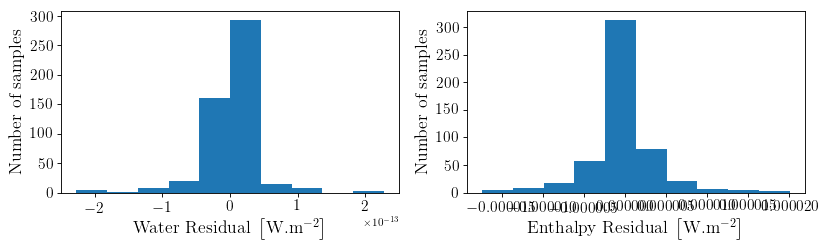

In [44]:
massent_check(x,yaft,fsub=fsub,fdiv=fdiv,normq=normq,hyai=hyai,hybi=hybi,outtype="graph")

## 3.4) Adapt mass-enthalpy conservation layer to new output format
tgb - 3/20/2019 - Adapt section above once works to correct random noise

In [27]:
class MulEntConsLay(Layer):
    
    def __init__(self, fsub, fdiv, normq, hyai, hybi, eps, output_dim, **kwargs):
        self.fsub = fsub # Subtraction for normalization of inputs 
        self.fdiv = fdiv # Division for normalization of inputs
        self.normq = normq # Normalization of output's water concentration
        self.hyai = hyai # CAM constants to calculate d_pressure
        self.hybi = hybi # CAM constants to calculate d_pressure
        self.eps = eps # Minimal denominator when calculating a ratio
        self.output_dim = output_dim # Dimension of output
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!
    
    # tgb - 2/6/2019 - following https://github.com/keras-team/keras/issues/4871
    def get_config(self):
        config = {'fsub': list(self.fsub), 'fdiv': list(self.fdiv),
                  'normq': list(self.normq), 'hyai': list(self.hyai),
                  'hybi': list(self.hybi), 'eps': list(self.eps),
                  'output_dim': self.output_dim}
        base_config = super(MulEntConsLay, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
        
    def call(self, arrs):        
        # Split between the inputs inp & the output of the densely connected
        # neural network, sradout
        inp, sradout = arrs
        
        # 0) Constants
        G = 9.80616; # Reference gravity constant [m.s-2]
        L_F = 3.337e5; # Latent heat of fusion of water [W.kg-1]
        L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
        L_S = tfm.add(L_F,L_V); # Latent heat of sublimation of water [W.kg-1]
        P0 = 1e5; # Reference surface pressure [Pa]   
        
        # Get non-dimensional pressure differences (p_tilde above)
        # In the input vector, PS is the 151st element after 
        # the first elements = [QBP, ..., VBP with shape 30*5=150]
        PS = tfm.add( tfm.multiply( inp[:,300], self.fdiv[300]), self.fsub[300])
        # Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
        P = tfm.add( tfm.multiply( P0, self.hyai), \
                    tfm.multiply( PS[:,None], self.hybi))
        dP = tfm.subtract( P[:, 1:], P[:, :-1])
        # norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
        dP_NORM = tfm.divide( \
                             tfm.multiply(self.normq[:30], \
                                   G), L_V)
        # dp_tilde = dp/dp_norm
        dP_TILD = tfm.divide( dP, dP_NORM)
        
        # WATER.1) Calculate water vertical integral from level 1 to level 30
        WATVEC = tfm.multiply( dP_TILD,tfm.add(tfm.add(sradout[:, :30],\
                                                       sradout[:, 30:60]),\
                                               sradout[:, 60:90]))
        WATINT = tfm.reduce_sum( WATVEC, axis=1)

        # WATER.2) Calculate forcing on the right-hand side (Net Evaporation-Precipitation)
        # E-P is already normalized to units W.m-2 in the output vector
        # so all we need to do is input-unnormalize LHF that is taken from the input vector
        LHF = tfm.add( tfm.multiply( x[:,303], self.fdiv[303]),\
                      self.fsub[303])
        # Note that total precipitation = PRECT + 1e-3*PRECTEND in the CAM model
        # PRECTEND already multiplied by 1e-3 in output vector so no need to redo it
        PREC = tfm.add( sradout[:, 214], sradout[:, 215])

        # WATER.FINAL) Ratio = (E-P)/(DWATER/DT)
        WATRAT = tfm.divide( tfm.subtract(LHF,PREC),\
                           tfm.multiply(tfm.sign(WATINT),\
                                        tfm.maximum(tfm.abs(WATINT), self.eps)))
        yint = tf.concat([tfm.multiply( sradout[:, :120],\
                                       tf.expand_dims(WATRAT,axis=1)),\
                          sradout[:, 120:]],1)

        # ENTHALPY.1) Calculate net energy input from phase change and precipitation
        # PHAS = Lf/Lv*((PRECST+PRECSTEN)-(PRECT+PRECTEND))
        PHAS = tfm.divide( tfm.multiply( tfm.subtract(\
                                              tfm.add( yint[:,216], yint[:,217]),\
                                              tfm.add( yint[:,214], yint[:,215])),\
                                      L_F),\
                         L_V)

        # ENTHALPY.2) Calculate net energy input from radiation, sensible heat flux and turbulent KE
        # 2.1) RAD = FSNT-FSNS-FLNT+FLNS
        RAD = tfm.add(\
                tfm.subtract( yint[:,210], yint[:,211]),\
                tfm.subtract( yint[:,213], yint[:,212]))
        # 2.2) Unnormalize sensible heat flux
        SHF = tfm.add( tfm.multiply( x[:,302], self.fdiv[302]),\
                      self.fsub[302])
        # 2.3) Net turbulent kinetic energy dissipative heating is the column-integrated 
        # turbulent kinetic energy energy dissipative heating
        KEDVEC = tfm.multiply( dP_TILD, yint[:, 180:210])
        KEDINT = tfm.reduce_sum( KEDVEC, axis=1)

        # ENTHALPY.3) Calculate tendency of normalized column water vapor due to phase change
        # 3.1) Column water vapor is the column integral of specific humidity
        PHQVEC = tfm.multiply( dP_TILD, yint[:, :30])
        PHQINT = tfm.reduce_sum( PHQVEC, axis=1)
        # 3.2) Multiply by L_S/L_V to normalize (explanation above)
        SPDQINT = tfm.divide( tfm.multiply( tfm.subtract(\
                                                         PHQINT, LHF),\
                                           L_S),\
                             L_V)

        # ENTHALPY.4) Same operation for liquid water tendency but multiplied by L_F/L_V
        SPDQCINT = tfm.divide( tfm.multiply(\
                                            tfm.reduce_sum(\
                                                           tfm.multiply( dP_TILD,\
                                                                        yint[:, 30:60]),\
                                                           axis=1),\
                                            L_F),\
                              L_V)

        # ENTHALPY.5) Same operation for temperature tendency
        DTINT = tfm.reduce_sum( tfm.multiply( dP_TILD[:, :30],\
                                             yint[:, 90:120]),\
                               axis=1)

        # ENTHALPY.FINAL) Ratio "beta" given above script
        DEN = tfm.add(DTINT,tfm.negative(KEDINT))
        ENTRAT1 = tfm.divide(tfm.add(tfm.add(tfm.add(RAD,SHF),PHAS),\
                                     tfm.divide(tfm.multiply(LHF,L_S),L_V)),\
                             tfm.multiply(tfm.sign(DEN),\
                                          tfm.maximum(self.eps,tfm.abs(DEN))))
        ENTRAT2 = tfm.divide(tfm.add(tfm.divide(tfm.multiply(PHQINT,L_S),L_V),SPDQCINT),\
                             tfm.multiply(tfm.sign(DEN),\
                                          tfm.maximum(self.eps,tfm.abs(DEN))))
        ENTRAT = tfm.subtract( ENTRAT1, ENTRAT2)
        out = tf.concat([yint[:, :90],\
                          tfm.multiply(yint[:, 90:120],tf.expand_dims(ENTRAT,axis=1)),\
                          yint[:, 120:180],\
                          tfm.multiply(yint[:, 180:210],tf.expand_dims(ENTRAT,axis=1)),\
                          yint[:, 210:218]],1)
        
        return out
    
    def compute_output_shape(self, input_shape):
        # tgb - 2/7/2019 - Wrap the returned output shape in Tensorshape
        # to avoid problems with custom layers & eager execution
        # https://github.com/tensorflow/tensorflow/issues/20805
        return tf.TensorShape((input_shape[0][0], self.output_dim)) 

# 4) Build neural networks

## 4.1) Formulate multiplicative-conserving model

In [37]:
# Conserving model with 5 dense layers
inp = Input(shape=(304,))
densout = Dense(512, activation='linear')(inp)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(218, activation='linear')(densout)
densout = LeakyReLU(alpha=0.3)(densout)
sradout = MulSurRadLay(
    input_shape=(218,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi, eps=1e-2, output_dim = 218
)([inp, densout])
out = MulEntConsLay(
    input_shape=(218,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi, eps=1e-2, output_dim = 218
)([inp, sradout])
CM_rad_5dens = Model(inputs=inp, outputs=out)

## 4.2) Compile the models
### 4.2.1) Use mean square error as loss function

In [38]:
CM_rad_5dens.compile('rmsprop','mse')

### 4.2.2) Check model summary

In [39]:
CM_rad_5dens.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 304)          0                                            
__________________________________________________________________________________________________
dense_54 (Dense)                (None, 512)          156160      input_10[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_54 (LeakyReLU)      (None, 512)          0           dense_54[0][0]                   
__________________________________________________________________________________________________
dense_55 (Dense)                (None, 512)          262656      leaky_re_lu_54[0][0]             
__________________________________________________________________________________________________
leaky_re_l

## 4.3) Train the models

### 4.3.1) Train compiled models

In [40]:
Nep = 2
hCM_rad_5dens = CM_rad_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=Nep, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)

Epoch 1/2
18240/18240 [==============================] - 330s 18ms/step - loss: 157141.8613 - val_loss: 47164.6214
Epoch 2/2
18240/18240 [==============================] - 301s 17ms/step - loss: 169381260.3321 - val_loss: 1027648.6252


### 4.3.2) Save models in .h5 format

In [13]:
%cd $TRAINDIR/HDF5_DATA
!pwd
# CM_rad_5dens.save('CM_rad_5dens.h5')

/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA


### 4.3.3) Loss and validation curves

In [41]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)

for index in range (1):
    if index==0: hdict = hCM_rad_5dens.history; colo = 'bo'; col = 'b'; lab = 'C';
    elif index==1: hdict = hU_rad_5dens.history; colo = 'ro'; col = 'r'; lab = 'U';
    elif index==2: hdict = hW001_rad_5dens.history; colo = 'go'; col = 'g'; lab = 'W001';
    elif index==3: hdict = hW05_rad_5dens.history; colo = 'co'; col = 'c'; lab = 'W05';
    elif index==4: hdict = hW099_rad_5dens.history; colo = 'mo'; col = 'm'; lab = 'W099';
        
    
    train_loss_values = hdict['loss']
    valid_loss_values = hdict['val_loss']
    epochs = range(1, len(train_loss_values) + 1)

    ax.plot(epochs, train_loss_values, colo, label=lab+' Train')
    ax.plot(epochs, valid_loss_values, col, label=lab+' Valid')

#plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (W/m^2)')
plt.ylim((0, 125))
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
# for legend at the right place
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True); 
plt.show()

RuntimeError: latex was not able to process the following string:
b'Loss (W/m^2)'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.16 (TeX Live 2015/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/tmp/matplotlib-y89yomes/tex.cache/fb5674ba346253e626ee9dfbf1012164.tex
LaTeX2e <2016/02/01>
Babel <3.9q> and hyphenation patterns for 10 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./fb5674ba346253e626ee9dfbf1012164.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...10.000000}{12.500000}{\rmfamily Loss (W/m^
                                                  2)}
No pages of output.
Transcript written on fb5674ba346253e626ee9dfbf1012164.log.




<Figure size 432x288 with 1 Axes>

### 4.3.4) Test predictions on one batch

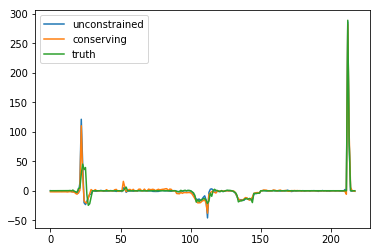

In [23]:
pred_cons = CM_rad_5dens.predict_on_batch(x)
ind_test = 150;
plt.plot(pred_cons[ind_test,:], label='conserving')
plt.plot(y[ind_test,:], label='truth')
plt.legend();

## 4.4) Check performances regarding mass/energy conservation and mean square error
tgb - 2/9/2019 - Adapted mass/energy conservation check to new output vector containing 60 more variables (longwave and shortwave heating profiles)

### 4.4.1) Mass/enthalpy conservation

In [28]:
xval, yval = next(validgen)
watres,entres = massent_check(xval,yval,fsub=fsub,fdiv=fdiv,normq=normq,hyai=hyai,hybi=hybi,outtype="list");
print(watres)
print(entres)

[ 6.18218541e-06 -3.62231227e-06  3.01862873e-06  1.48028206e-05
 -1.77397528e-05  5.73493472e-06 -1.84131817e-06 -3.06033769e-06
 -5.36547003e-06  3.69375047e-06  3.51215739e-07  1.84152078e-05
 -1.17641766e-06 -3.66041281e-06 -1.23043492e-06 -2.42369387e-06
 -8.51148607e-06 -1.12099237e-06 -4.62391594e-06  4.06213803e-06
 -6.16809302e-07 -8.39637752e-06  7.46351640e-06 -1.30527059e-06
  9.69236232e-06 -1.69989448e-05 -1.89040775e-06  1.36581469e-07
  1.78542662e-07 -2.18636700e-07  1.61298279e-06  1.64922257e-06
 -1.14914060e-06 -2.43718453e-06  1.43827156e-06 -9.52250539e-07
  9.27454940e-06  3.14079817e-07  3.12846890e-07  5.94551260e-06
  1.56130549e-05  6.97460714e-06 -3.61450489e-06  4.92597220e-06
 -3.25596034e-06 -3.43917307e-07  1.58050186e-06 -4.03532504e-06
  4.21205610e-06  2.09266030e-06 -3.33906607e-05 -3.18008711e-06
  6.10945129e-07  4.40447343e-06 -4.60314563e-06 -2.20304853e-05
 -3.19277251e-06 -1.02213505e-05 -9.57491244e-06 -6.87257465e-07
 -6.46314256e-07 -2.06690

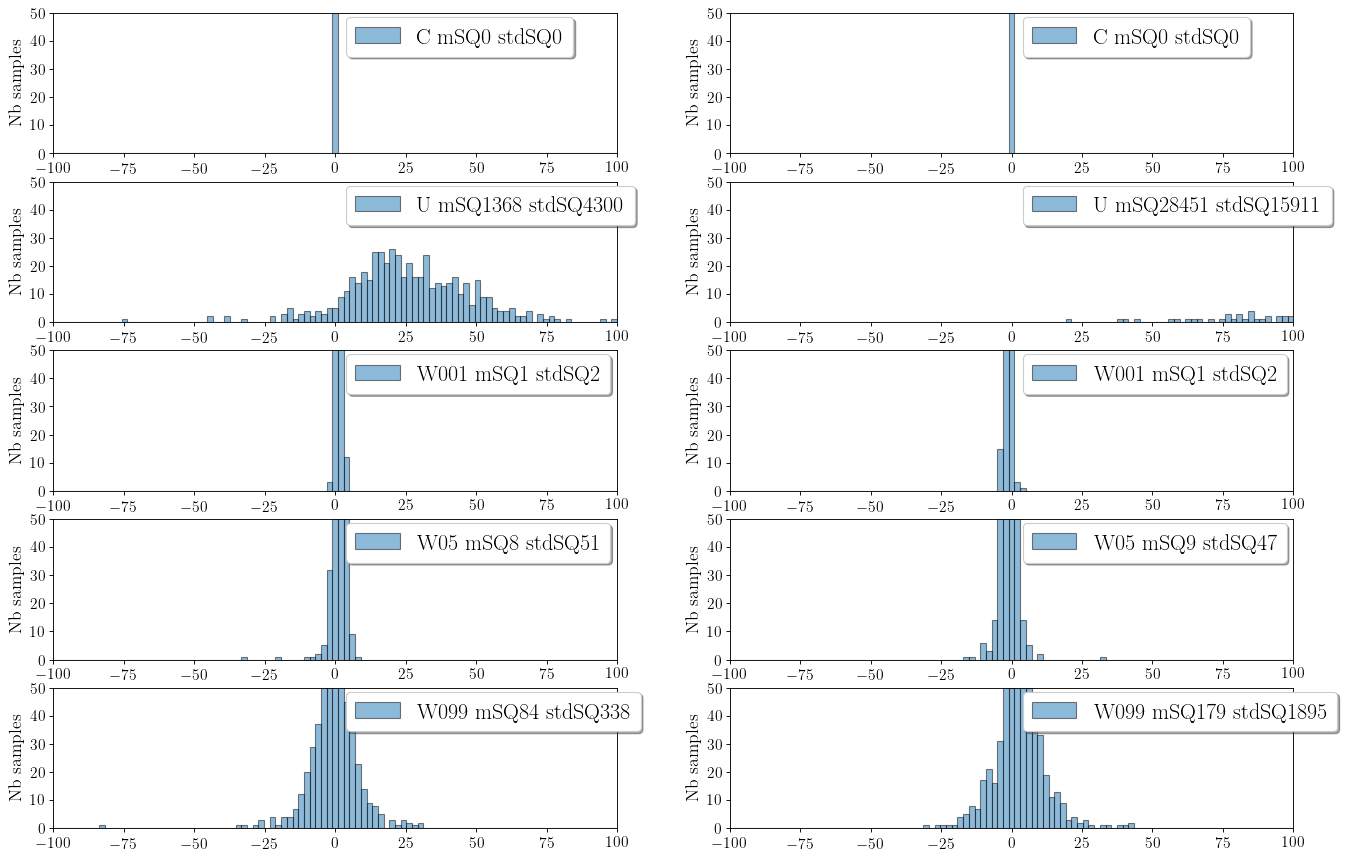

In [14]:
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(num=None, figsize=(20, 13.5), dpi=80, facecolor='w', edgecolor='k')
XMAX = 100; bins = np.linspace(-XMAX, XMAX, 100)

xval, yval = next(gen)

for index in range (1):
    if index==1: pred = CM_rad_5dens.predict_on_batch(xval); lab = 'CM';
    elif index==0: pred = C_rad_5dens.predict_on_batch(xval); lab = 'C';
    elif index==2: pred = W001_rad_5dens.predict_on_batch(xval); lab = 'W001';
    elif index==3: pred = W05_rad_5dens.predict_on_batch(xval); lab = 'W05';
    elif index==4: pred = W099_rad_5dens.predict_on_batch(xval); lab = 'W099';

    watres,entres = massent_check(xval,pred,fsub=fsub,fdiv=fdiv,normq=normq,hyai=hyai,hybi=hybi,outtype="list");

    ax = plt.subplot(5,2,2*index+1)
    ax.hist(watres, bins, alpha=0.5, edgecolor='k', label = lab+' mSQ%i' %np.mean(watres**2)+' stdSQ%i' %np.std(watres**2))
    plt.ylabel(r'Nb samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    plt.ylim((0, 50)); plt.xlim((-XMAX, XMAX));
    ax.legend(loc='upper left', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True, fontsize = 20);
    
    ax = plt.subplot(5,2,2*index+2)
    ax.hist(entres, bins, alpha=0.5, edgecolor='k', label = lab+' mSQ%i' %np.mean(entres**2)+' stdSQ%i' %np.std(entres**2))
    plt.ylabel(r'Nb samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    plt.ylim((0, 50)); plt.xlim((-XMAX, XMAX));
    ax.legend(loc='upper left', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True, fontsize = 20); 

### 4.4.2) Mean square error

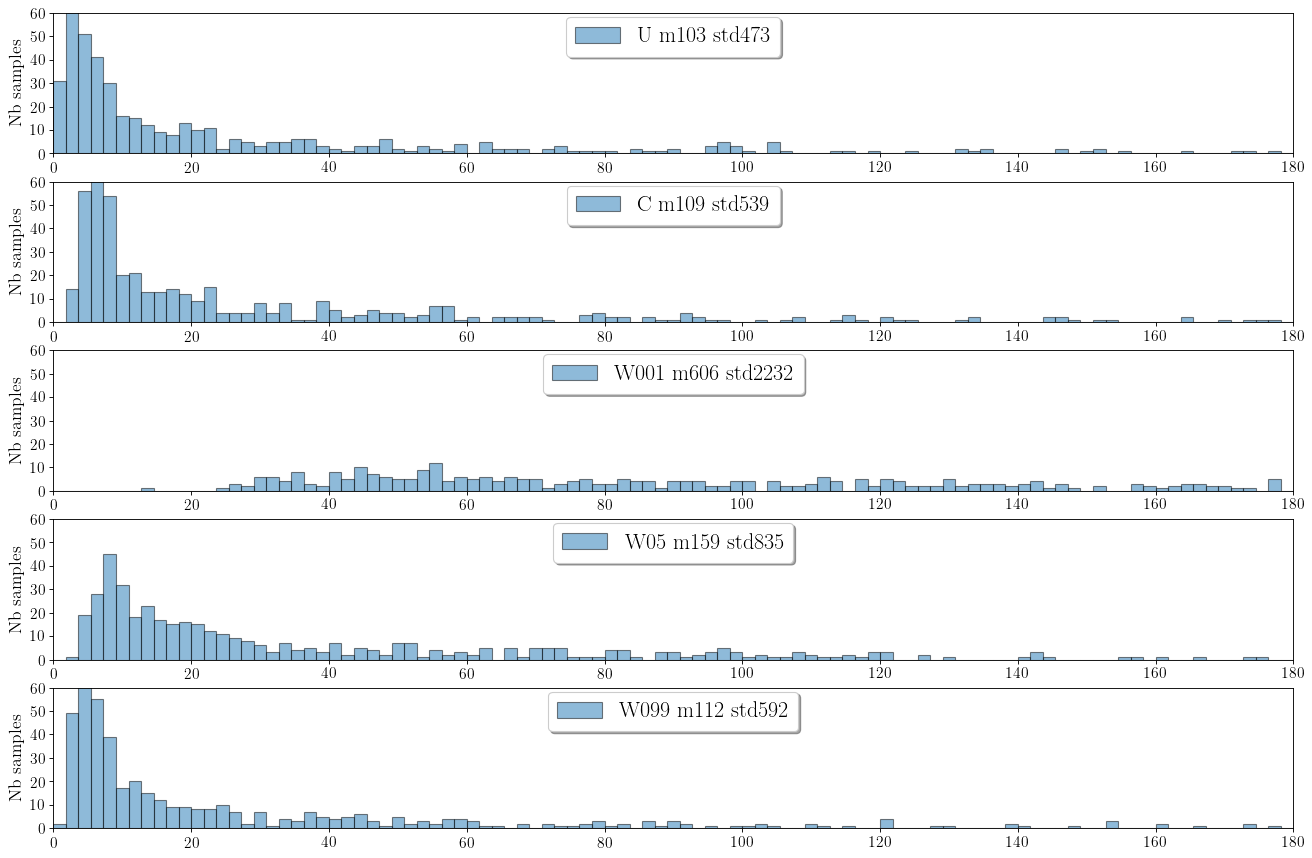

In [16]:
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(num=None, figsize=(20, 13.5), dpi=80, facecolor='w', edgecolor='k')
XMAX = 180; bins = np.linspace(0, XMAX, 100)

xval, yval = next(gen)

for index in range (1):
    if index==0: pred = CM_rad_5dens.predict_on_batch(xval); lab = 'CM';
    elif index==1: pred = C_rad_5dens.predict_on_batch(xval); lab = 'C';
    elif index==2: pred = W001_rad_5dens.predict_on_batch(xval); lab = 'W001';
    elif index==3: pred = W05_rad_5dens.predict_on_batch(xval); lab = 'W05';
    elif index==4: pred = W099_rad_5dens.predict_on_batch(xval); lab = 'W099';

    res = np.mean((pred-yval)**2, axis=1);
    
    ax = plt.subplot(5,1,index+1)
    ax.hist(res, bins, alpha=0.5, edgecolor='k', label = lab+' m%i' %np.mean(res)+' std%i' %np.std(res))
    plt.ylabel(r'Nb samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    plt.ylim((0, 60)); plt.xlim((0, XMAX));
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True, fontsize = 20); 

### 4.4.3) Check radiative integrals

In [29]:
def radint_check(x,y,fsub=fsub,fdiv=fdiv,normq=normq,hyai=hyai,hybi=hybi):
    import copy
    inp = copy.copy(x)

    # 0) Constants
    C_P = 1.00464e3 # Specific heat capacity of air at constant pressure
    G = 9.80616; # Reference gravity constant [m.s-2]
    P0 = 1e5; # Reference surface pressure [Pa]

    # 1) Get non-dimensional pressure differences (p_tilde above)
    PS = np.add( np.multiply( inp[:,300], fdiv[300]), fsub[300])
    # Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
    P = np.add( np.multiply( P0, hyai), \
                np.multiply( PS[:,None], hybi))
    dP = np.subtract( P[:, 1:], P[:, :-1])
    # norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
    dP_NORM = np.divide( \
                         np.multiply(normq[:30], \
                               G), L_V)
    # dp_tilde = dp/dp_norm
    # Wondering about broadcasting here...
    # tf.div or simply \ would support broadcasting 
    dP_TILD = np.divide( dP, dP_NORM)

    # 2) Radiative integrals
    SWVEC = np.multiply( dP_TILD, y[:, 150:180])
    SWINT = np.sum( SWVEC, axis=1)
    SWNET = y[:,210]-y[:,211] # FSNT-FSNS

    LWVEC = np.multiply( dP_TILD, y[:, 120:150])
    LWINT = np.sum( LWVEC, axis=1) # LW integral
    LWNET = y[:,213]-y[:,212] # FLNS-FLNT

    return (SWINT-SWNET), (LWINT-LWNET)

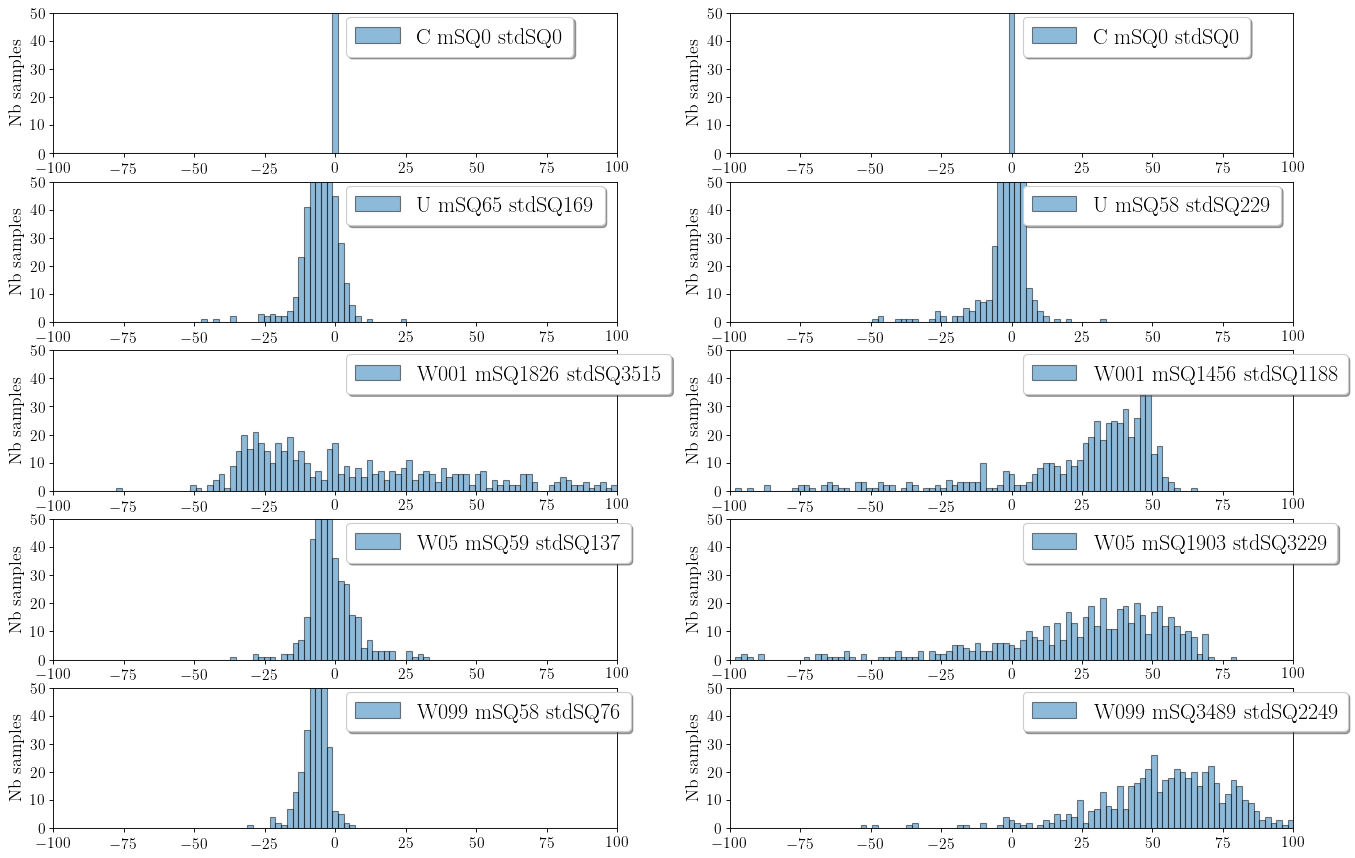

In [31]:
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(num=None, figsize=(20, 13.5), dpi=80, facecolor='w', edgecolor='k')
XMAX = 100; bins = np.linspace(-XMAX, XMAX, 100)

xval, yval = next(gen)

for index in range (1):
    if index==1: pred = CM_rad_5dens.predict_on_batch(xval); lab = 'CM';
    elif index==0: pred = C_rad_5dens.predict_on_batch(xval); lab = 'C';
    elif index==2: pred = W001_rad_5dens.predict_on_batch(xval); lab = 'W001';
    elif index==3: pred = W05_rad_5dens.predict_on_batch(xval); lab = 'W05';
    elif index==4: pred = W099_rad_5dens.predict_on_batch(xval); lab = 'W099';

    swres,lwres = radint_check(xval,pred,fsub=fsub,fdiv=fdiv,normq=normq,hyai=hyai,hybi=hybi)

    ax = plt.subplot(5,2,2*index+1)
    ax.hist(swres, bins, alpha=0.5, edgecolor='k', label = lab+' mSQ%i' %np.mean(swres**2)+' stdSQ%i' %np.std(swres**2))
    plt.ylabel(r'Nb samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    plt.ylim((0, 50)); plt.xlim((-XMAX, XMAX));
    ax.legend(loc='upper left', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True, fontsize = 20);
    
    ax = plt.subplot(5,2,2*index+2)
    ax.hist(lwres, bins, alpha=0.5, edgecolor='k', label = lab+' mSQ%i' %np.mean(lwres**2)+' stdSQ%i' %np.std(lwres**2))
    plt.ylabel(r'Nb samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    plt.ylim((0, 50)); plt.xlim((-XMAX, XMAX));
    ax.legend(loc='upper left', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True, fontsize = 20); 

#### Step 6: Check positivity of water species
There are two necessary steps:  
1) Load the water species concentrations "before physics" from the input vector and unnormalize them  
2) Invert the output normalization to get the water concentrations "after physics"

$$
\delta q_{v,i,l}\left(p\right)=\frac{L_{v}\Delta p_{\mathrm{norm}}}{g}\frac{q_{v,i,l}^{a}\left(p\right)-q_{v,i,l}^{b}\left(p\right)}{\Delta t}\ \Rightarrow\ q_{v,i,l}^{a}\left(p\right)=q_{v,i,l}^{b}\left(p\right)+\frac{g\Delta t}{L_{v}\Delta p_{\mathrm{norm}}}\delta q_{v,i,l}\left(p\right)
$$

In [145]:
def watpos_check(x,y,fsub=fsub,fdiv=fdiv,normq=normq,dt=30*60):
    
    import numpy as np

    # 1) Extract water species concentrations from inputs
    QVB = np.add( np.multiply( x[:, :30], fdiv[ :30]), fsub[ :30])
    QLB = np.add( np.multiply( x[:, 30:60], fdiv[ 30:60]), fsub[ 30:60])
    QSB = np.add( np.multiply( x[:, 60:90], fdiv[ 60:90]), fsub[ 60:90])

    # 2) Inverse output normalization and get water concentration after physics
    QVA = QVB + np.divide( dt*y[:, :30] , normq[:30])
    QLA = QLB + np.divide( dt*y[:, 30:60] , normq[:30])
    QSA = QSB + np.divide( dt*y[:, 60:90] , normq[:30])

    import matplotlib.pyplot as plt
    from matplotlib import rc
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

    plt.subplot(231)
    plt.hist(1e3*QVA)
    plt.xlabel(r"$\mathrm{Water\ vapor\ concentration\ \left[g/kg\right]}$", fontsize=16)
    plt.ylabel(r'Number of samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)

    plt.subplot(232)
    plt.hist(1e3*QLA)
    plt.xlabel(r"$\mathrm{Liquid\ water\ concentration\ \left[g/kg\right]}$", fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)

    plt.subplot(233)
    plt.hist(1e3*QSA)
    plt.xlabel(r"$\mathrm{Ice\ concentration\ \left[g/kg\right]}$", fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    
    plt.subplot(234)
    plt.hist(1e3*(QVA-QVB))
    plt.xlabel(r"$\mathrm{Water\ vapor\ change\ \left[g/kg\right]}$", fontsize=16)
    plt.ylabel(r'Number of samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)

    plt.subplot(235)
    plt.hist(1e3*(QLA-QLB))
    plt.xlabel(r"$\mathrm{Liquid\ water\ change\ \left[g/kg\right]}$", fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)

    plt.subplot(236)
    plt.hist(1e3*(QSA-QSB))
    plt.xlabel(r"$\mathrm{Ice\ change\ \left[g/kg\right]}$", fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

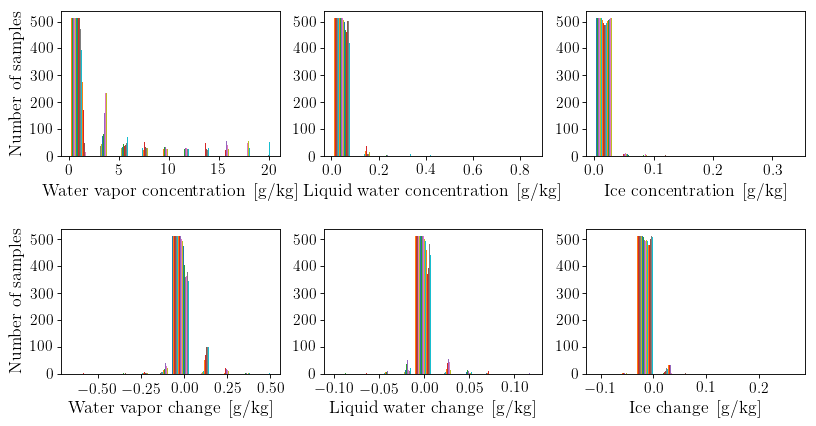

In [146]:
watpos_check(xval,yval,fsub,fdiv,normq,dt)